In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import dask
print(f'dask: {dask.__version__}')
import dask.array
dask.config.set({'array.chunk-size': '512MiB'})

import xarray as xr

from psutil import virtual_memory

mem = virtual_memory()
print(f'Physical memory: {mem.total/1024/1024/1024:.0f} Gb')  # total physical memory available

import logging
logging.basicConfig(filename='example.log', level=logging.DEBUG)

import os

dask: 2.11.0
Physical memory: 504 Gb


In [2]:
%load_ext autoreload

%autoreload 2

import toolbox_scs as tb
print(tb.__file__)
import toolbox_scs.routines.boz as boz

from extra_data.read_machinery import find_proposal

/home/lleguy/notebooks/ToolBox/src/toolbox_scs/__init__.py


# Loading analysis parameters

In [3]:
proposal = 2937
runNB = 690
darkrunNB = 671
moduleNB = 15
gain = 3
drop_intra_darks = True

In [4]:
root = find_proposal(f'p{proposal:06d}')
path = root + f'/usr/processed_runs/'
params = boz.parameters.load(path + 'r0614/parameters_p2937_d615_r614.json')

In [5]:
rpath = path + f'r{runNB:04d}/'
prefix = prefix = f'p{proposal}-r{runNB}-d{darkrunNB}-BOZ-II1'
os.makedirs(rpath, exist_ok=True)

# Dark run inspection

The aim is to check dark level and extract bad pixel map.

In [6]:
arr_dark, tid_dark = boz.load_dssc_module(proposal, darkrunNB, moduleNB, drop_intra_darks=drop_intra_darks)
arr_dark = arr_dark.rechunk(('auto',-1,-1,-1))

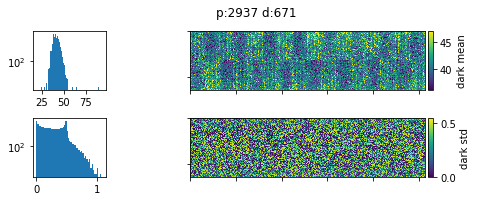

In [7]:
f = boz.inspect_dark(arr_dark)
f.suptitle(f'p:{proposal} d:{darkrunNB}')
fname = rpath + prefix + '-inspect_dark.png'
f.savefig(fname, dpi=300) 

# Veto pattern check

Check potential veto pattern issue

In [8]:
dark = boz.average_module(arr_dark).compute()
arr, tid = boz.load_dssc_module(proposal, runNB, moduleNB, drop_intra_darks=drop_intra_darks)
arr = arr.rechunk(('auto',-1,-1,-1))
data = boz.average_module(arr, dark=dark).compute()
pp = data.mean(axis=(1,2)) # pulseId resolved mean
dataM = data.mean(axis=0) # mean over pulseId

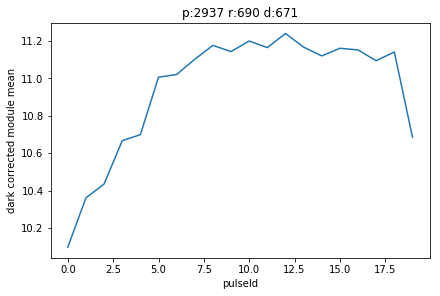

In [9]:
plt.figure()
plt.plot(pp)
plt.xlabel('pulseId')
plt.ylabel('dark corrected module mean')
plt.title(f'p:{proposal} r:{runNB} d:{darkrunNB}')
plt.savefig(rpath+prefix+'-inspect_veto.png', dpi=300)

In [10]:
"""
# Thresholding out bad veto pulse
if False:
    params.arr = params.arr[:, pp > 2, :, :]
    params.arr_dark = params.arr_dark[:, pp > 2, :, :]
    dark = boz.average_module(params.arr_dark).compute()
    data = boz.average_module(params.arr, dark=dark).compute()
    dataM = data.mean(axis=0) # mean over pulseId
"""

'\n# Thresholding out bad veto pulse\nif False:\n    params.arr = params.arr[:, pp > 2, :, :]\n    params.arr_dark = params.arr_dark[:, pp > 2, :, :]\n    dark = boz.average_module(params.arr_dark).compute()\n    data = boz.average_module(params.arr, dark=dark).compute()\n    dataM = data.mean(axis=0) # mean over pulseId\n'

# Check ROIs

Let's check the ROIs used in the part I on a run later

it's a bit off, also we can see from the blur that the photon energy was varied in this run.

In [11]:
rois_th = 1.2
rois = boz.find_rois(dataM, rois_th)

In [12]:
rois = params.rois

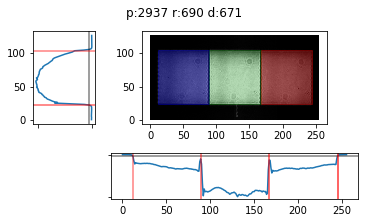

In [13]:
f = boz.inspect_rois(dataM, rois, rois_th)

f.suptitle(f'p:{proposal} r:{runNB} d:{darkrunNB}')
fname = rpath + prefix + '-inspect_rois.png'
f.savefig(fname, dpi=300) 

We got new rois.

# Compute flat field with new rois

We use the previously fitted plane on the new roi.

In [14]:
ff = boz.compute_flat_field_correction(rois, params)

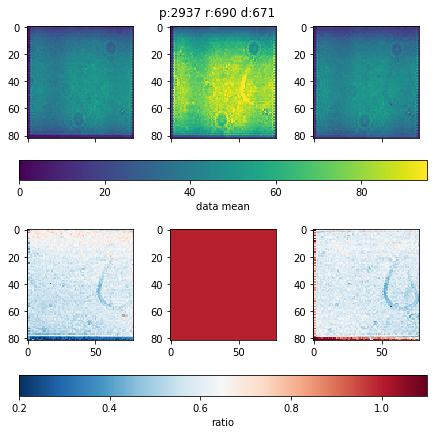

In [15]:
f = boz.inspect_plane_fitting(dataM/ff, rois)

f.suptitle(f'p:{proposal} r:{runNB} d:{darkrunNB}')
fname = rpath + prefix + '-inspect_plane_fitting.png'
f.savefig(fname, dpi=300)

# Process a run

In [16]:
#no correction
#data = boz.process(np.arange(2**9), arr_dark, arr, tid, rois, params.get_mask(),
#                   np.ones_like(ff), params.sat_level)
#with flat field correction
#data = boz.process(np.arange(2**9), arr_dark, arr, tid, rois, params.get_mask(),
#                      ff, params.sat_level)
# with flat field and non linear correction
data = boz.process(params.get_Fnl(), arr_dark, arr, tid, rois, params.get_mask(),
                         ff, params.sat_level)

# Saturation histogram

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/r0690/p2937-r690-d671-BOZ-II1-inspect_saturation.h5


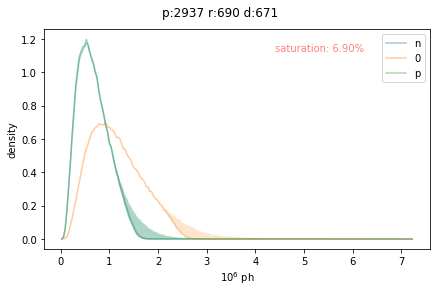

In [17]:
f, h = boz.inspect_saturation(data, gain)

f.suptitle(f'p:{proposal} r:{runNB} d:{darkrunNB}')
fname = rpath + prefix + '-inspect_saturation.png'
f.savefig(fname, dpi=300)

fname = rpath + prefix + f'-inspect_saturation.h5'
print(fname)
h.to_netcdf(fname, format='NETCDF4', engine='h5netcdf')

# Drop saturated shot

In [18]:
# filter saturated shots
d = data.where(data['sat_sat'] == False, drop=True)
d.attrs['saturation (%)'] = h.attrs['saturation (%)']
print(f"{d.attrs['saturation (%)']:.2f} % of shots were saturated")

6.90 % of shots were saturated


# Load rest of data

In [19]:
run, data = tb.load(proposal, runNB, ['PP800_DelayLine', 'nrj', 'BAM1932S'])

In [20]:
# overwrite DSSC pulseId with BAM sa3_pId
d = d.rename(pulseId = 'sa3_pId')
d['sa3_pId'] = data['sa3_pId']

In [21]:
r = xr.merge([data, d], join='inner', combine_attrs='no_conflicts')

In [22]:
#BAM jitter correction
bam = r['BAM1932S'] - r['BAM1932S'].mean()
r['delay_ps'] = tb.positionToDelay(r['PP800_DelayLine']) + bam
# converting back to mm after BAM correction
r['delay_mm'] = tb.delayToPosition(r['delay_ps'])

# Save the processed data

In [23]:
# save the result
fname = rpath + prefix + f'-small-data.h5'
print(fname)
r.to_netcdf(fname, format='NETCDF4', engine='h5netcdf')

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/r0690/p2937-r690-d671-BOZ-II1-small-data.h5
